In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import sys
import random
sys.path.append('../')
import torch
import torch.nn as nn
from models.modules import fc, FC
from models.ae import AE, NRAE_L, NRAE_Q
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
from IPython.display import clear_output

device = f'cuda:{0}'

In [2]:
# Setup seeds
seed = 1
print(f"running with random seed : {seed}")
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

running with random seed : 1


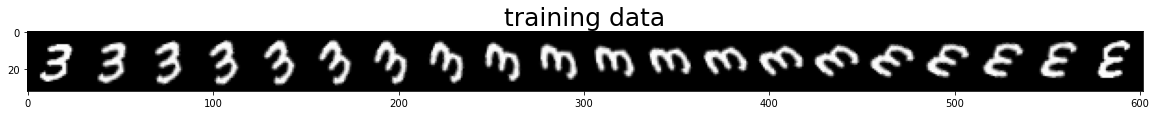

In [3]:
data = torch.tensor(np.load('../datasets/rot_mnist_digit_3.npy'))
fig, ax = plt.subplots(figsize=(20, 2))
plt.title('training data', fontsize=25)
ax.imshow(make_grid(data, nrow=20).permute(1,2,0))
plt.show()

In [4]:
class Custom_Dataset(Dataset):
    def __init__(self, dataset, nn=False, num_nn=20):
        super().__init__()
        self.data = dataset
        self.num_nn = num_nn
        self.nn = nn
        if self.nn:
            data_temp = self.data.view(len(self.data), -1).clone()
            dist_mat = torch.cdist(data_temp, data_temp)
            dist_mat_indices = torch.topk(
                dist_mat, k=self.num_nn + 1, dim=1, largest=False, sorted=True
            )
            self.dist_mat_indices = dist_mat_indices.indices[:, 1:]
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        X = self.data[idx]
        if self.nn:
            X_nn = self.data[
                self.dist_mat_indices[
                    idx, 
                    np.random.choice(range(self.num_nn), 1, replace=False)]]
            return X, X_nn
        else:
            return X

# 1. The Vanilla Autoencoder

In [5]:
x_dim = 784
z_dim = 1

encoder = FC(
    in_chan=x_dim,
    out_chan=z_dim,
    l_hidden=[32,32],
    activation=['relu','relu'],
    out_activation='linear'
) 
decoder = FC(
    in_chan=z_dim,
    out_chan=x_dim,
    l_hidden=[32,32],
    activation=['relu','relu'],
    out_activation='linear'
)
ae = AE(encoder, decoder).to(device)

dataset = Custom_Dataset(data, nn=False)
train_dl = DataLoader(dataset, batch_size=5)

optimizer = torch.optim.Adam(ae.parameters(), lr=0.001)

In [6]:
for epoch in range(1000):
    Loss = []
    for x in train_dl:
        d_loss = ae.train_step(x.to(device), optimizer=optimizer)
        Loss.append(d_loss['loss'])
    print(f'epoch:{epoch}, loss:{sum(Loss)/len(Loss)}')
    clear_output(wait=True)

epoch:999, loss:0.003872516332194209


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


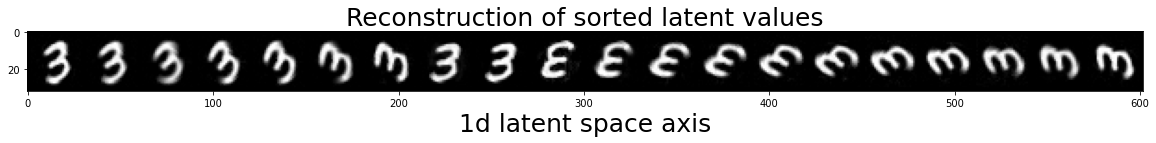

In [7]:
z_train_dataset = ae.encoder_mean(data.to(device))
z_sorted = torch.sort(z_train_dataset, dim=0)[0]
X_gen = ae.decoder_mean(z_sorted)

fig, ax = plt.subplots(figsize=(20,2))
plt.title('Reconstruction of sorted latent values', fontsize=25)
ax.imshow(make_grid(X_gen.detach().cpu(), nrow=20).permute(1,2,0))
plt.xlabel('1d latent space axis', fontsize=25)
plt.show()

# 2. Neighborhood Reconstructing Autoencoder (Linear)

In [8]:
x_dim = 784
z_dim = 1

encoder = FC(
    in_chan=x_dim,
    out_chan=z_dim,
    l_hidden=[32,32],
    activation=['relu','relu'],
    out_activation='linear'
) 
decoder = FC(
    in_chan=z_dim,
    out_chan=x_dim,
    l_hidden=[32,32],
    activation=['relu','relu'],
    out_activation='linear'
)
nrae_l = NRAE_L(encoder, decoder, lamb=0.001).to(device)

dataset = Custom_Dataset(data, nn=True, num_nn=2)
train_dl = DataLoader(dataset, batch_size=5)

optimizer = torch.optim.Adam(nrae_l.parameters(), lr=0.001)

In [9]:
loss_avg = np.inf
epoch = 0
while loss_avg > 0.01:
    epoch = epoch + 1
    Loss = []
    for x, x_nn in train_dl:
        d_loss = nrae_l.train_step(x.to(device), x_nn.to(device), optimizer=optimizer)
        Loss.append(d_loss['loss'])
    print(f'epoch:{epoch}, loss:{sum(Loss)/len(Loss)}')
    loss_avg = sum(Loss)/len(Loss)
    clear_output(wait=True)

epoch:1016, loss:0.009915994014590979


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


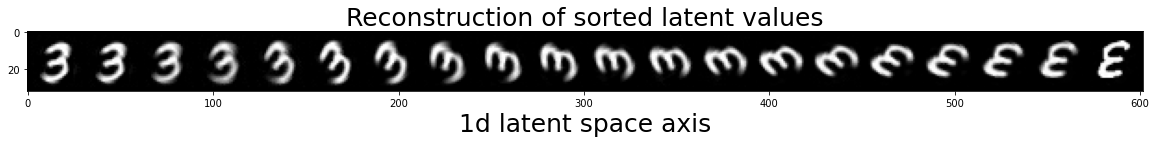

In [10]:
z_train_dataset = nrae_l.encoder_mean(data.to(device))
z_sorted = torch.sort(z_train_dataset, dim=0)[0]
X_gen = nrae_l.decoder_mean(z_sorted)

fig, ax = plt.subplots(figsize=(20,2))
plt.title('Reconstruction of sorted latent values', fontsize=25)
ax.imshow(make_grid(X_gen.detach().cpu(), nrow=20).permute(1,2,0))
plt.xlabel('1d latent space axis', fontsize=25)
plt.show()

# 3. Neighborhood Reconstructing Autoencoder (Quadratic)

In [13]:
x_dim = 784
z_dim = 1

encoder = FC(
    in_chan=x_dim,
    out_chan=z_dim,
    l_hidden=[32,32],
    activation=['relu','relu'],
    out_activation='linear'
) 
decoder = FC(
    in_chan=z_dim,
    out_chan=x_dim,
    l_hidden=[32,32],
    activation=['relu','relu'],
    out_activation='linear'
)
nrae_q = NRAE_Q(encoder, decoder, lamb=0.001).to(device)

dataset = Custom_Dataset(data, nn=True, num_nn=2)
train_dl = DataLoader(dataset, batch_size=5)

optimizer = torch.optim.Adam(nrae_q.parameters(), lr=0.001)

In [14]:
loss_avg = np.inf
epoch = 0
while loss_avg > 0.01:
    epoch = epoch + 1
    Loss = []
    for x, x_nn in train_dl:
        d_loss = nrae_q.train_step(x.to(device), x_nn.to(device), optimizer=optimizer)
        Loss.append(d_loss['loss'])
    print(f'epoch:{epoch}, loss:{sum(Loss)/len(Loss)}')
    loss_avg = sum(Loss)/len(Loss)
    clear_output(wait=True)

epoch:5318, loss:0.009748026845045388


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


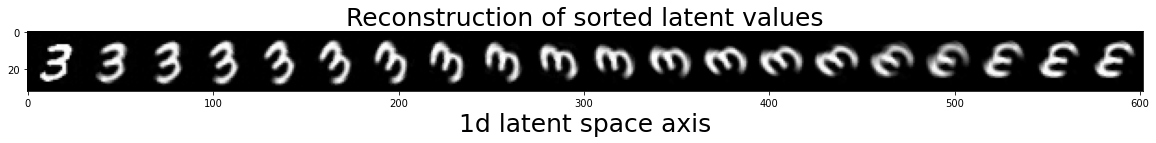

In [15]:
z_train_dataset = nrae_q.encoder_mean(data.to(device))
z_sorted = torch.sort(z_train_dataset, dim=0)[0]
X_gen = nrae_q.decoder_mean(z_sorted)

fig, ax = plt.subplots(figsize=(20,2))
plt.title('Reconstruction of sorted latent values', fontsize=25)
ax.imshow(make_grid(X_gen.detach().cpu(), nrow=20).permute(1,2,0))
plt.xlabel('1d latent space axis', fontsize=25)
plt.show()